In [1]:
%load_ext autoreload
%autoreload 2
import sys
import copy
import torch
import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import abstract_gradient_training as agt
from abstract_gradient_training.bounds import interval_bound_propagation as ibp
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics
sys.path.append("../")
from models.fully_connected import FullyConnected
from datasets.blobs import get_dataloaders

# Preliminaries

Set the plotting style, abstract gradient training configuration, prepare the blobs dataset and initialise the model.

In [2]:
# Set plotting and functional parameters
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)
MARKERSIZE = 20
GRIDSIZE = 1000
GRIDLIM = 3.8
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = mpl.colors.ListedColormap(["#ffffff", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"])
CM_UNLEARNING = mpl.colors.ListedColormap(["#ffffff", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"])

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=2,
    device="cuda:0",
    forward_bound="interval,crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    lr_min=1e-3,
    early_stopping=False,
    log_level="WARNING",
)

In [3]:
DL_TRAIN_CLOSE, DL_TEST_CLOSE = get_dataloaders(BATCHSIZE, 1, 0.75, SEED)
DL_TRAIN_FAR, DL_TEST_FAR = get_dataloaders(BATCHSIZE, 1.25, 0.35, SEED)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

# Sweep and plotting functions

Define functions for sweeping over a specific AGT config parameter and plotting the results as a contour plot.

In [4]:
results_dir = ".results"
notebook_id = "blobs_smooth_sens"

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(SEED)
        if config.metadata == "close":
            dl_train, dl_test = DL_TRAIN_CLOSE, DL_TEST_CLOSE
        elif config.metadata == "far":
            dl_train, dl_test = DL_TRAIN_FAR, DL_TEST_FAR
        else:
            raise ValueError("metadata should be either close or far")
        
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                MODEL, config, dl_train, dl_test
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                MODEL, config, dl_train, dl_test
            )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

# Run all sweeps

Define the sweep configurations and run all sweeps to get parameter bounds.

In [5]:
config = copy.deepcopy(NOMINAL_CONFIG)
config.clip_gamma = 0.08

In [6]:
# Run sweeps for close and far blobs datasets, for privacy and unlearning
KS_PRIVACY = list(range(0, 200, 5))
KS_UNLEARNING = list(range(0, 200, 5))
privacy_results_close = {}
privacy_results_far = {}
unlearning_results_close = {}
unlearning_results_far = {}

for k in KS_PRIVACY:
    config = copy.deepcopy(NOMINAL_CONFIG)
    config.clip_gamma = 0.08
    config.k_private = k
    config.metadata = "close"
    privacy_results_close[k] = run_with_config(config)
    config.metadata = "far"
    privacy_results_far[k] = run_with_config(config)
    
for k in KS_UNLEARNING:
    config = copy.deepcopy(NOMINAL_CONFIG)
    config.clip_gamma = 0.08
    config.k_unlearn = k
    config.metadata = "close"
    unlearning_results_close[k] = run_with_config(config)
    config.metadata = "far"
    unlearning_results_far[k] = run_with_config(config)
    

/tmp/ipykernel_2213120/3227111557.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


In [7]:
def compute_max_certified_k(test_batch, test_labels, privacy_results):
    """Compute the maximum k for which we can certify each data point."""
    k_max = torch.zeros_like(test_labels, device=NOMINAL_CONFIG.device).squeeze()
    
    for k, (param_l, param_n, param_u) in privacy_results.items():
        cert = test_metrics.proportion_certified(
            param_n,
            param_l,
            param_u,
            test_batch,
            test_labels,
            model=MODEL,
            transform=ct_utils.propagate_conv_layers,
            reduce=False,
        ).to(NOMINAL_CONFIG.device)  # boolean vector stating whether each test point is certified (sens=0) or not (sens=1)
        k_max = torch.max(k_max, k * cert)  # update the maximum k value which we can certify for each test point
    
    k_max = k_max + 1 # add 1 to the maximum k value to get the minimum k value which we cannot certify
    
    return k_max

def compute_smooth_sens(results, epsilon=1.0, delta=10 ** -5):
    # define a grid of points to evaluate the model at
    x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    # add polynomial features
    in_data = torch.stack(
        (
            X.flatten(),
            Y.flatten(),
            X.flatten() ** 2,
            Y.flatten() ** 2,
            X.flatten() ** 3,
            Y.flatten() ** 3,
        ),
        dim=1,
    )
    in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float() 
    
    beta = epsilon / (2 * math.log(2 / delta))

    k_max = compute_max_certified_k(in_data, torch.ones(in_data.size(0), device=NOMINAL_CONFIG.device), results)
    smooth_sens = torch.exp(-2 * beta * k_max)
    return smooth_sens


def plot_sweep(smooth_sens, logits, dl_test, ax, cm, plot_cbar=False, location="right", cbar_label="", norm=None):
    """
    Given the parameter bounds in the results list returned from run_sweep, compute the worst-case predictions for a
    grid of points covering the half-moon dataset and plot the results as a contour plot.
    """

    # get the whole test dataset
    x_test, y_test = dl_test.dataset.tensors

    # define a grid of points to evaluate the model at
    x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    ax.contour(X, Y, logits, cmap=CM_NOMINAL, alpha=1.0, levels=[0.5], linewidths=1.5)
    
    if norm is None:
        norm = mpl.colors.LogNorm(vmin=smooth_sens.min(), vmax=1.0)
    # cont = ax.contour(X, Y, smooth_sens.reshape(GRIDSIZE, GRIDSIZE), levels=200, norm=norm, cmap=cm, )

    cont = ax.imshow(np.rot90(smooth_sens.reshape(GRIDSIZE, GRIDSIZE)), extent=[-GRIDLIM, GRIDLIM, -GRIDLIM, GRIDLIM], norm=norm, cmap=cm)

    if plot_cbar:
        cbar = plt.colorbar(
            cont, location=location, ax=ax, shrink=0.8, label="Smooth Sensitivity"
        )
        # cbar.ax.set_ylim(1e-6, 1.0)
        cbar.ax.tick_params(length=0, width=0, which="minor")
    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.5, cmap=CM_BRIGHT)
    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.5, cmap=CM_BRIGHT)
    
    return norm, cont

# Plot all results

Plot the results of all sweeps, showing the "certified" region for each setting of k.

In [24]:
smooth_sens_close = compute_smooth_sens(privacy_results_close, epsilon=1.0).cpu().numpy().reshape(GRIDSIZE, GRIDSIZE)
smooth_sens_far = compute_smooth_sens(privacy_results_far, epsilon=1.0).cpu().numpy().reshape(GRIDSIZE, GRIDSIZE)
# define a grid of points to evaluate the model at
x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
X, Y = torch.meshgrid(x, y)

# add polynomial features
in_data = torch.stack(
    (
        X.flatten(),
        Y.flatten(),
        X.flatten() ** 2,
        Y.flatten() ** 2,
        X.flatten() ** 3,
        Y.flatten() ** 3,
    ),
    dim=1,
)

in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float()

param_n = privacy_results_close[0][1]
*_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
logits_close = logits.detach().cpu().numpy()

param_n = privacy_results_far[0][1]
*_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
logits_far = logits.detach().cpu().numpy()

In [25]:
print(smooth_sens_close.min(), smooth_sens_close.max())

0.0003839732 0.9213397


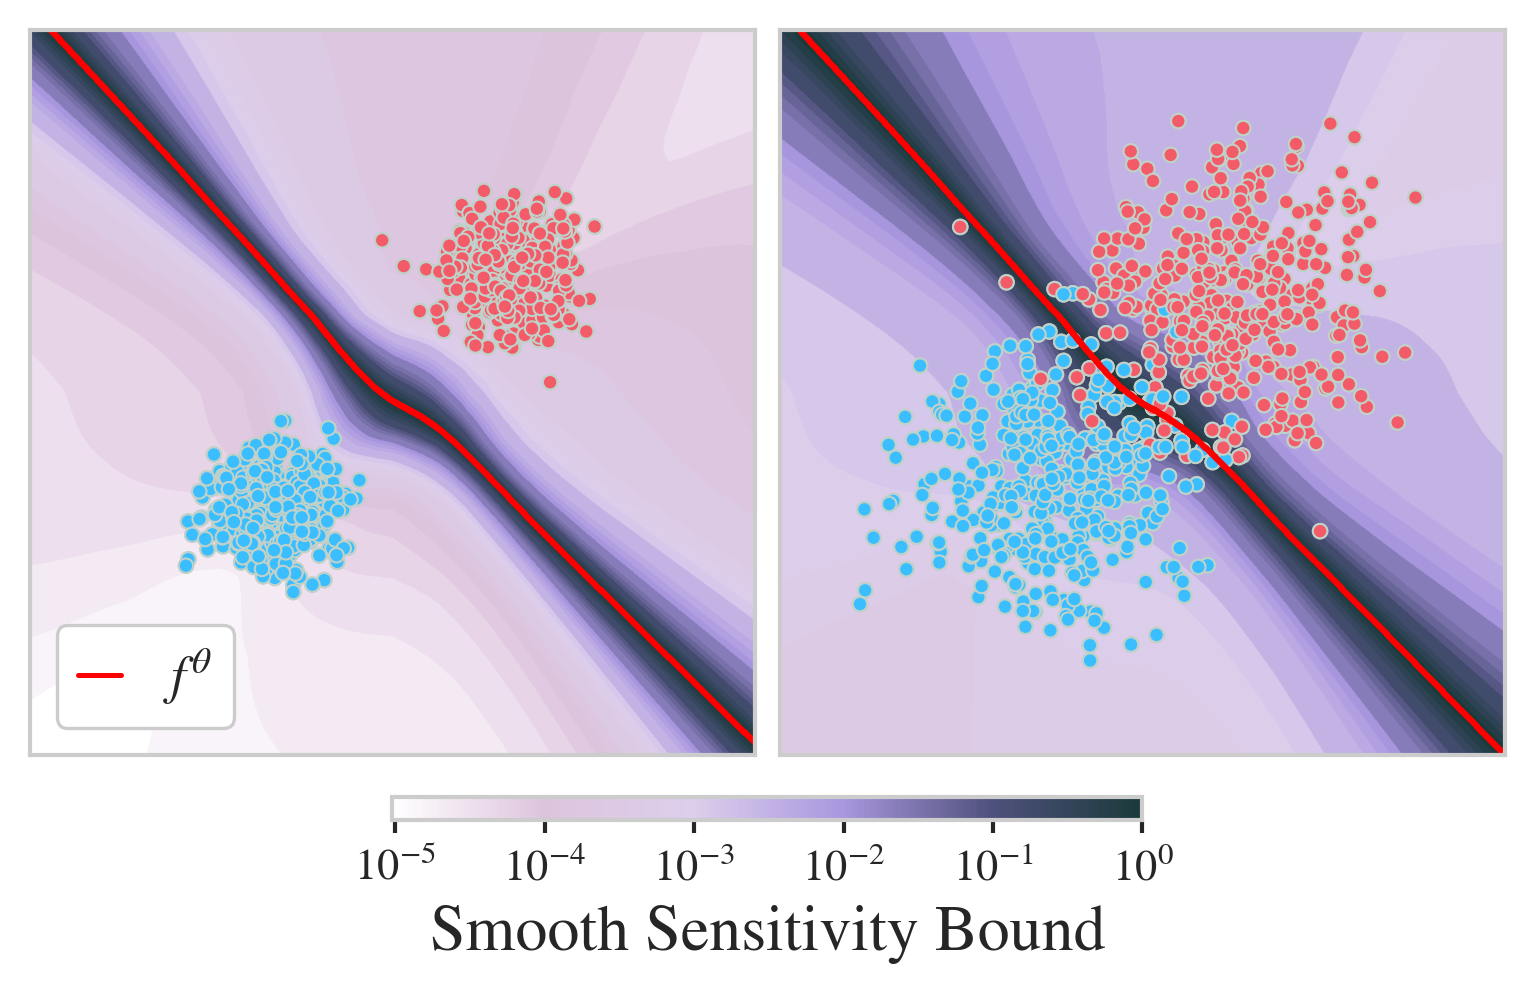

In [26]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.6)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"], n_colors=200, as_cmap=True
)
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"], n_colors=200, as_cmap=True
)

# CM_PRIVACY = sns.color_palette("BuGn_r", as_cmap=True, n_colors=200)
MARKERSIZE = 12
GRIDSIZE = 1000
GRIDLIM = 3.8

fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 2.5),
    dpi=300,
    sharey=True,
    layout="constrained",
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for ax in axs:
    ax.set_aspect("equal")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-GRIDLIM, GRIDLIM)
    ax.set_ylim(-GRIDLIM, GRIDLIM)

norm, cont = plot_sweep(smooth_sens_far, logits_far, DL_TEST_FAR, axs[0], CM_PRIVACY, False)
norm, cont = plot_sweep(smooth_sens_close, logits_close, DL_TEST_CLOSE, axs[1], CM_PRIVACY, False, norm=norm)

cbar_ax = fig.add_axes([0.25, -0.07, 0.5, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=CM_PRIVACY, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    label="Smooth Sensitivity Bound",
    shrink=1.5,
)
cbar.ax.tick_params(length=0, width=0, which="minor")
cbar.ax.tick_params(length=3, width=1, which="major", labelsize="x-small")
# cbar.ax.set_xlim(1e-5, 1.0)
cbar.ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

red_line = mpl.lines.Line2D([], [], color="red", label=r"$f^{\theta}$")
axs[0].legend(
    handles=[red_line], loc="lower left", handlelength=0.8, fontsize="small", bbox_to_anchor=(-0.0, -0.0), framealpha=1.0
)

plt.savefig(".figures/blobs_privacy_smooth_sens.pdf", bbox_inches="tight", dpi=350)

In [11]:
import numpy as np
from scipy.special import lambertw

test_point_far, test_label_far = next(iter(DL_TEST_FAR))

In [12]:
def get_cauchy_noise_level(test_batch, test_labels, privacy_results, epsilon):
    """Compute the noise level for the Cauchy mechanism."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    gamma = 2  # for Cauchy distribution
    beta = epsilon / (2 * (gamma + 1)) - 1e-7
    smooth_sens = torch.exp(-2 * beta * k_max)
    noise_level = 2 * (gamma + 1) * smooth_sens / epsilon
    return noise_level

def compute_local_epsilons(test_batch, test_labels, privacy_results, epsilon, delta):
    """Compute the local epsilon for each test point, via the smooth sensitivity bound."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    
    k_max = k_max.cpu().numpy()
    local_epsilons = math.log(2 / delta) * lambertw(2 * epsilon * k_max / math.log(2 / delta)) / k_max
    local_epsilons = local_epsilons.real  # should always be real, but output of lambertw is complex
    local_epsilons = torch.tensor(local_epsilons, device=NOMINAL_CONFIG.device)
    local_epsilons = local_epsilons.clamp(max=epsilon)
    return local_epsilons


In [13]:
epsilons = torch.logspace(-2, 1, 40)

cauchy_means = []
cauchy_stds = []
laplace_means = []
laplace_stds = []

n_runs = 100

for epsilon in epsilons:
    noise_level = get_cauchy_noise_level(test_point_far, test_label_far, privacy_results_far, float(epsilon)) + 1e-8
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            test_metrics.test_accuracy(
                *privacy_results_far[0],
                test_point_far,
                test_label_far,
                model=MODEL,
                transform=ct_utils.propagate_conv_layers,
                noise_level=noise_level,
                noise_type="cauchy",
            )[1]
        )
        private_accs_laplace.append(
            test_metrics.test_accuracy(
                *privacy_results_far[0],
                test_point_far,
                test_label_far,
                model=MODEL,
                transform=ct_utils.propagate_conv_layers,
                noise_level=float(1 / epsilon),
                noise_type="laplace",
            )[1]
        )
    cauchy_means.append(np.mean(private_accs_cauchy))
    cauchy_stds.append(np.std(private_accs_cauchy))
    laplace_means.append(np.mean(private_accs_laplace))
    laplace_stds.append(np.std(private_accs_laplace))

print(laplace_means)
print(cauchy_means)

[np.float64(0.5016600239276886), np.float64(0.5051600241661072), np.float64(0.5056200256943703), np.float64(0.5019400241971016), np.float64(0.5020200237631798), np.float64(0.5061600229144096), np.float64(0.5020400223135948), np.float64(0.5044800227880478), np.float64(0.5128800258040428), np.float64(0.5093400254845619), np.float64(0.5190600249171257), np.float64(0.5179000231623649), np.float64(0.51776002317667), np.float64(0.5246800228953361), np.float64(0.5327400264143943), np.float64(0.5371200287342072), np.float64(0.5433800238370895), np.float64(0.5491000288724899), np.float64(0.5569800299406051), np.float64(0.5672800290584564), np.float64(0.584600026011467), np.float64(0.5946200305223465), np.float64(0.6121200275421143), np.float64(0.6271400320529937), np.float64(0.6459600281715393), np.float64(0.6727600300312042), np.float64(0.6996200335025787), np.float64(0.7233200341463089), np.float64(0.7579000324010849), np.float64(0.786480039358139), np.float64(0.8217200428247452), np.float64(

In [14]:
"""Add constant noise, and compute the local epsilons."""

delta = 10 ** -5

local_eps = []

for epsilon in epsilons:
    epsilon = float(epsilon)
    local_epsilons = compute_local_epsilons(test_point_far, test_label_far, privacy_results_far, epsilon, delta)
    local_eps.append(local_epsilons.mean().item())

print(epsilons)
print(local_eps)

tensor([1.0000e-02, 1.1938e-02, 1.4251e-02, 1.7013e-02, 2.0309e-02, 2.4245e-02,
        2.8943e-02, 3.4551e-02, 4.1246e-02, 4.9239e-02, 5.8780e-02, 7.0170e-02,
        8.3768e-02, 1.0000e-01, 1.1938e-01, 1.4251e-01, 1.7013e-01, 2.0309e-01,
        2.4245e-01, 2.8943e-01, 3.4551e-01, 4.1246e-01, 4.9239e-01, 5.8780e-01,
        7.0170e-01, 8.3768e-01, 1.0000e+00, 1.1938e+00, 1.4251e+00, 1.7013e+00,
        2.0309e+00, 2.4245e+00, 2.8943e+00, 3.4551e+00, 4.1246e+00, 4.9239e+00,
        5.8780e+00, 7.0170e+00, 8.3768e+00, 1.0000e+01])
[0.009999999776482582, 0.011937766335904598, 0.014251026324927807, 0.017012542113661766, 0.020309176295995712, 0.02424461953341961, 0.028942661359906197, 0.034551072865724564, 0.041246265172958374, 0.04923882707953453, 0.058780159801244736, 0.06986384728198931, 0.07921366661265208, 0.08751758228883949, 0.09624300867182749, 0.10539503501568799, 0.1149647036699982, 0.12493337333122491, 0.13528196994135766, 0.14599134229193553, 0.15704254485427732, 0.16841709513

In [15]:
noise_free_acc = test_metrics.test_accuracy(
        *privacy_results_far[0], test_point_far, test_label_far, model=MODEL, transform=ct_utils.propagate_conv_layers
    )[1]


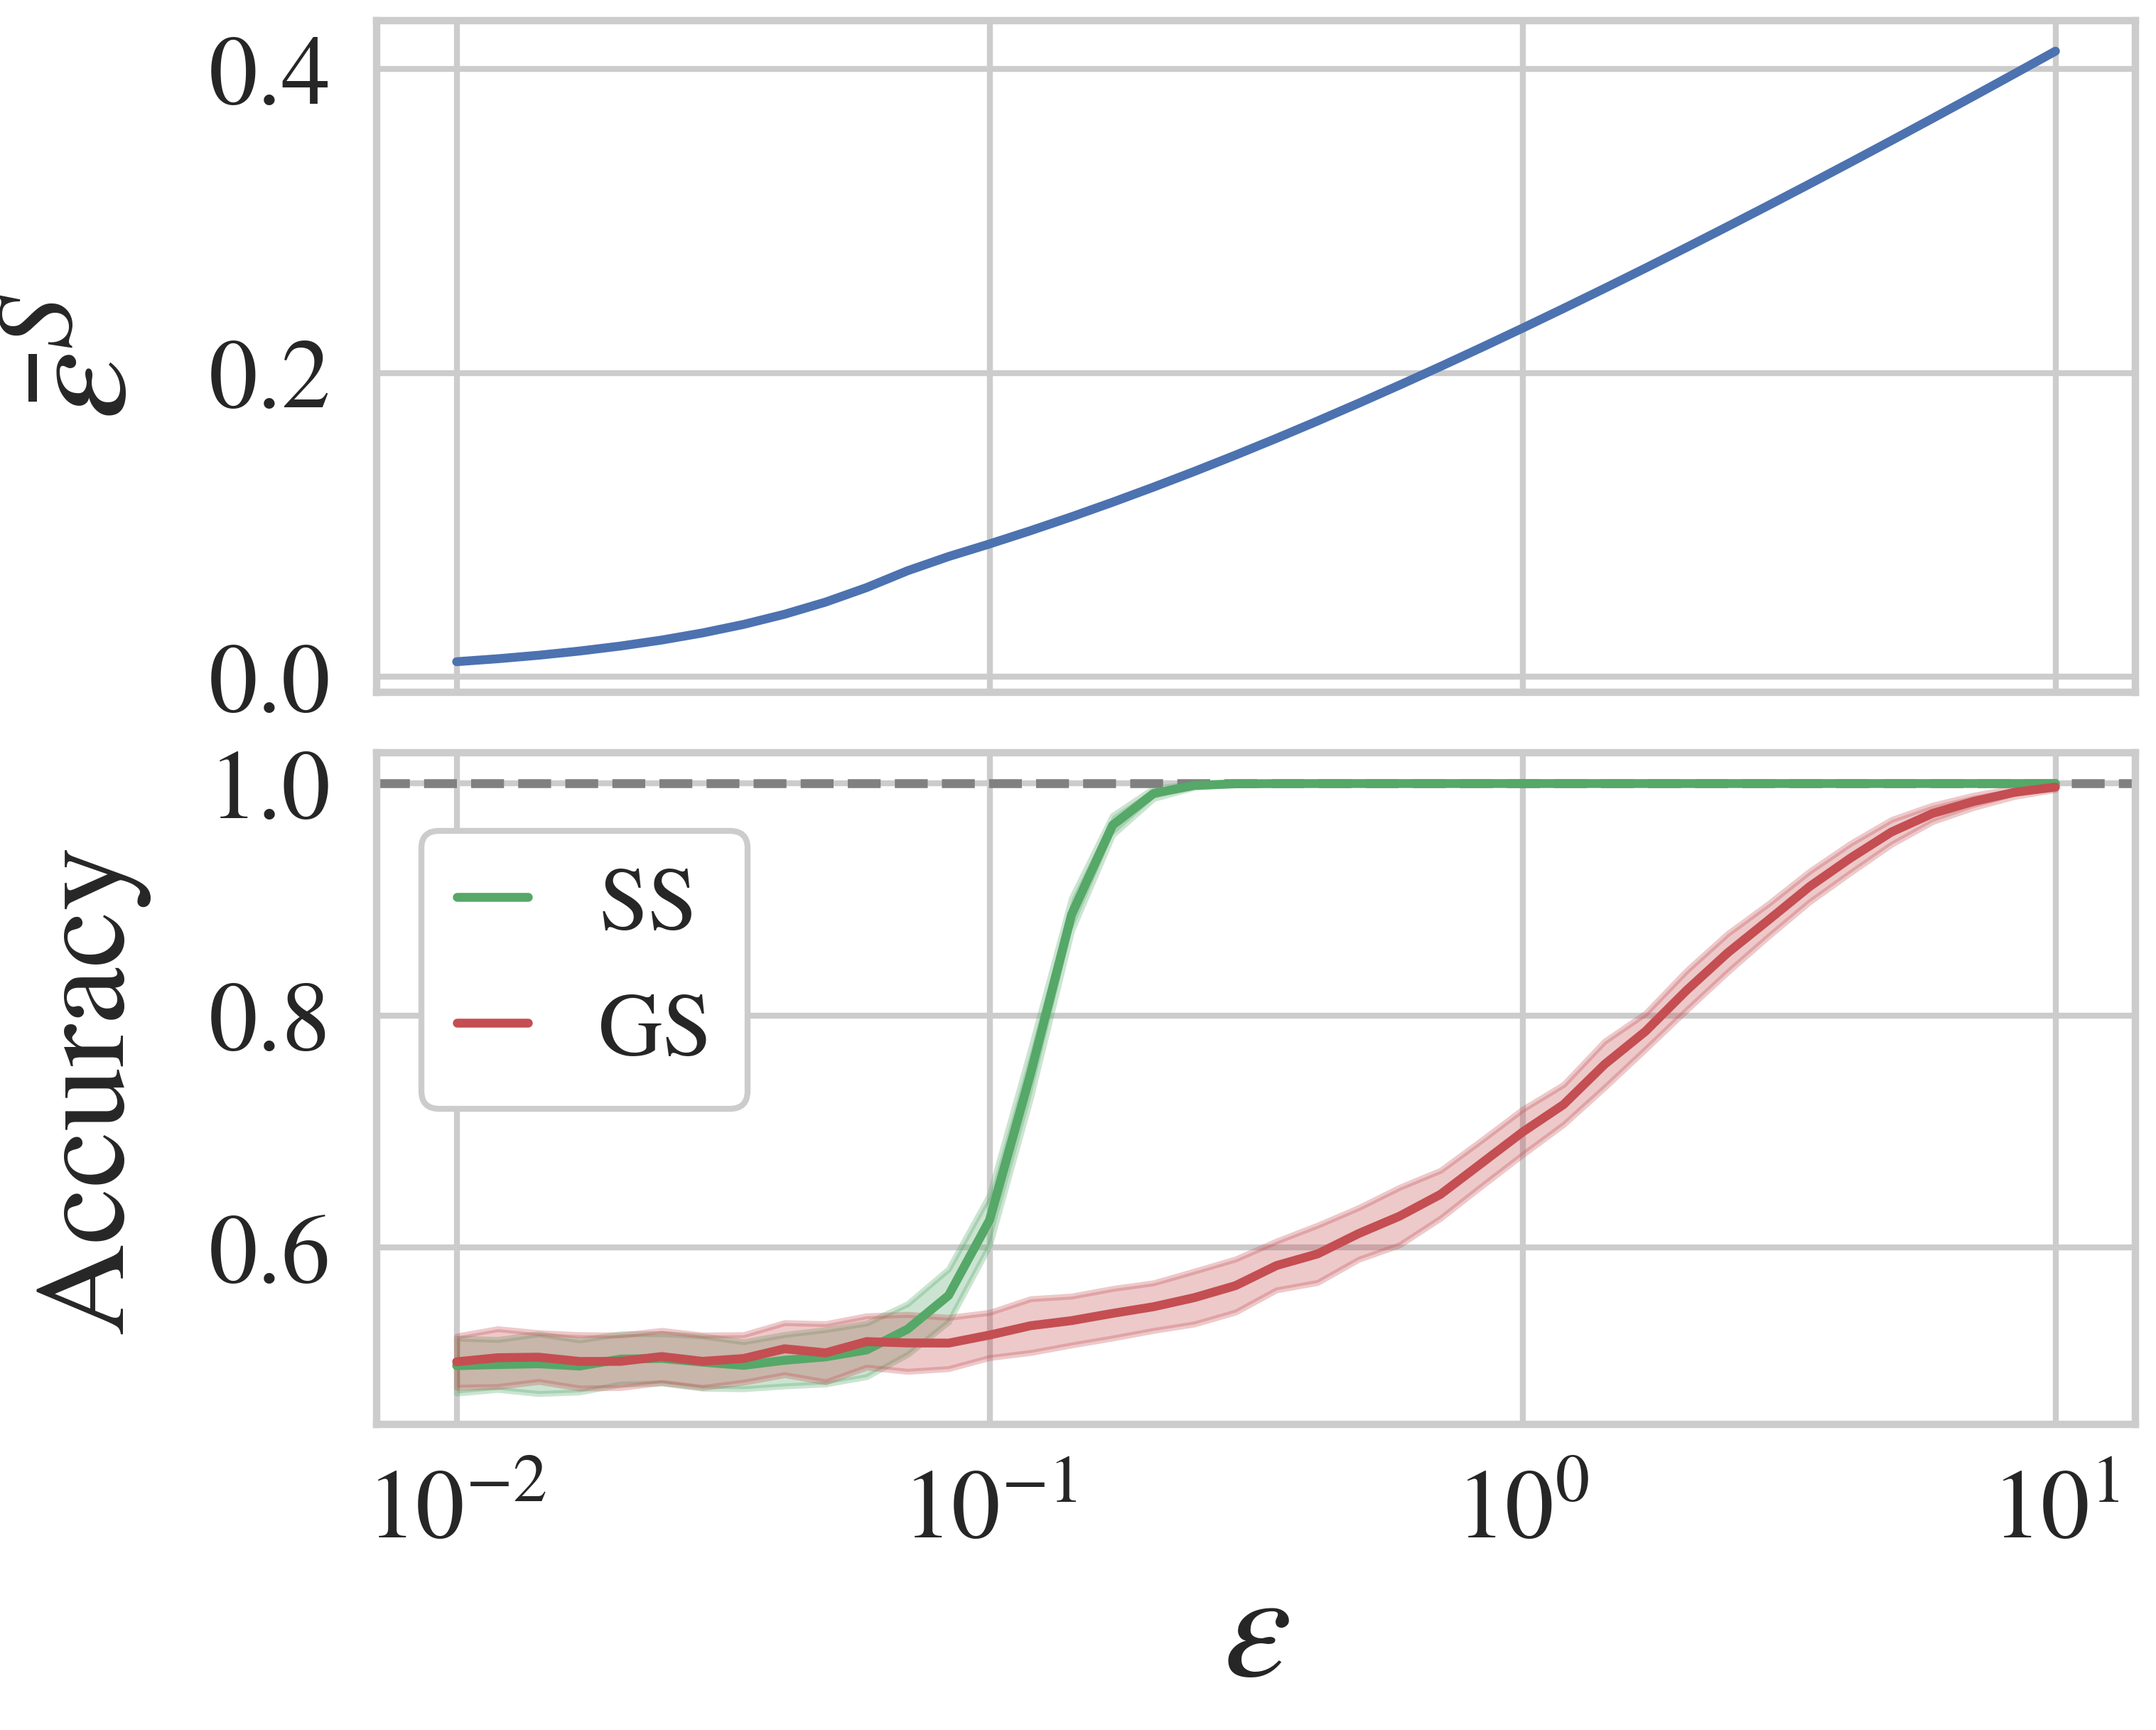

In [16]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

# fig, axs = plt.subplots(2, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained", sharex=True, dpi=300)

axs[0].set_xscale("log")
axs[1].set_xlabel("$\epsilon$", fontsize="x-large")

# axs[0].plot(epsilons, np.array(local_eps) / np.array(epsilons), c=barcolor)
axs[0].plot(epsilons, np.array(local_eps), c=barcolor)

axs[1].set_ylabel("Accuracy", fontsize="large", labelpad=20)
axs[0].set_ylabel(r"${\bar{\epsilon}^S}$", fontsize="x-large", labelpad=40, va="center")

axs[1].axhline(noise_free_acc, c="gray", linestyle="--")
axs[1].plot(epsilons, cauchy_means, c=cauchycolor, label="SS")
axs[1].fill_between(
    epsilons,
    np.array(cauchy_means) - np.array(cauchy_stds),
    np.array(cauchy_means) + np.array(cauchy_stds),
    color=cauchycolor,
    alpha=0.3,
)
axs[1].plot(epsilons, laplace_means, c=laplacecolor, label="GS")
axs[1].fill_between(
    epsilons,
    np.array(laplace_means) - np.array(laplace_stds),
    np.array(laplace_means) + np.array(laplace_stds),
    color=laplacecolor,
    alpha=0.3,
)
axs[1].legend(loc="upper left", handlelength=0.8, framealpha=1.0, bbox_to_anchor=(0.0, 0.95), fontsize="small")
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
plt.savefig(".figures/blobs_ss_usage_far.pdf", bbox_inches="tight", dpi=300)